In [33]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [34]:
df=pd.read_csv("datasets/cleandf.csv")

In [35]:
df=df.drop(columns="Unnamed: 0")

In [36]:
pd.set_option('display.max_columns', None)

## LSTM (time series)
#### Trying to predict the overall score in future reviews

In [37]:
# Data manipulation
# ==============================================================================
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print('Skforecast version: ', skforecast.__version__)

Skforecast version:  0.12.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90008 entries, 0 to 90007
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AIRLINENAME          90008 non-null  object
 1   CABINTYPE            90008 non-null  int64 
 2   DATEFLOWN            90008 non-null  object
 3   DATEPUB              90008 non-null  object
 4   ENTERTAINMENTRATING  90008 non-null  int64 
 5   FOODRATING           90008 non-null  int64 
 6   GROUNDSERVICERATING  90008 non-null  int64 
 7   ORIGINCOUNTRY        90008 non-null  object
 8   OVERALLSCORE         90008 non-null  int64 
 9   RECOMMENDED          90008 non-null  int64 
 10  REVIEW               90008 non-null  object
 11  ROUTE                90008 non-null  object
 12  ORIGIN               90008 non-null  object
 13  DESTINY              89996 non-null  object
 14  SCALE_YN             90008 non-null  int64 
 15  SEATCOMFORTRATING    90008 non-null  int64 
 16  SERV

In [39]:
#stay only with those airlines which have 2k+ reviews:
review_counts = df.groupby('AIRLINENAME').size().reset_index(name='REVIEW_COUNT')

# Filter airlines with at least 10 reviews
airlines_with_min_reviews = review_counts[review_counts['REVIEW_COUNT'] >= 2000]['AIRLINENAME']

# Filter the original DataFrame to include only those airlines
time = df[df['AIRLINENAME'].isin(airlines_with_min_reviews)]

# Display the resulting DataFrame
time.sample()

,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
70525,Spirit Airlines,1,2018-04-01,2nd April 2018,0,0,1,UnitedStates,1,0,Las Vegas to Los Angeles. This airline is horr...,Las Vegas to Los Angeles,Las Vegas,Los Angeles,0,1,1,spirit-airlines,This airline is horrid,2,1,1,1,0,149b6f0d-0ab5-4de3-97f5-c55a4e0884e6,0,2018


In [40]:
time.reset_index(drop=True, inplace=True)

In [41]:
dateflown_score=time.groupby(['DATEFLOWN'])['OVERALLSCORE'].mean().reset_index()

In [42]:
from datetime import datetime

In [43]:
dateflown_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATEFLOWN     107 non-null    object 
 1   OVERALLSCORE  107 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [44]:
#check the extreme dates:
print(dateflown_score.DATEFLOWN.min())
print(dateflown_score.DATEFLOWN.max())

2014-07-01
2023-05-01


In [45]:
clean = dateflown_score[(dateflown_score.DATEFLOWN >= '2016-01-01 00:00:00') & (dateflown_score.DATEFLOWN < '2024-01-01 00:00:00')]

In [46]:
clean.shape

(88, 2)

In [47]:
clean.head()

,DATEFLOWN,OVERALLSCORE
19,2016-02-01,3.827778
20,2016-03-01,4.102439
21,2016-04-01,4.000000
22,2016-05-01,4.115646
23,2016-06-01,3.553846


In [48]:
clean.DATEFLOWN.unique()

array(['2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
       '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
       '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
       '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
       '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
       '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
       '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
       '2021-02-01', '2021-03-01', '2021-04-01', '2021-

In [49]:
clean

,DATEFLOWN,OVERALLSCORE
19,2016-02-01,3.827778
20,2016-03-01,4.102439
21,2016-04-01,4.000000
22,2016-05-01,4.115646
23,2016-06-01,3.553846
...,...,...
102,2023-01-01,2.163043
103,2023-02-01,2.282486
104,2023-03-01,1.794872
105,2023-04-01,1.930041


In [50]:
clean.isna().sum() #no missing data!

DATEFLOWN       0
OVERALLSCORE    0
dtype: int64

In [51]:
clean2 = dateflown_score[(dateflown_score.DATEFLOWN >= '2021-01-01 00:00:00') & (dateflown_score.DATEFLOWN < '2024-01-01 00:00:00')]

In [52]:
# Data preparation
# ==============================================================================
clean = clean2.set_index('DATEFLOWN') 
clean = clean2.asfreq('MS') #frequency: monthly started
clean = clean2.sort_index()
clean.head()

,DATEFLOWN,OVERALLSCORE
79,2021-02-01,2.440000
80,2021-03-01,1.478723
81,2021-04-01,1.959732
82,2021-05-01,2.153333
83,2021-06-01,1.740299


In [53]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 79 to 106
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATEFLOWN     28 non-null     object 
 1   OVERALLSCORE  28 non-null     float64
dtypes: float64(1), object(1)
memory usage: 672.0+ bytes


In [54]:
#check number of missingness, should be 0
print(f'Number of rows with missing values: {clean.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values: {clean.isnull().sum()}')

Number of rows with missing values: 0.0
Number of rows with missing values: DATEFLOWN       0
OVERALLSCORE    0
dtype: int64


In [55]:
clean.index == pd.date_range(start=clean.index.min(),
                            end=clean.index.max(),
                            freq=clean.index.freq).all()

AttributeError: 'Index' object has no attribute 'freq'

In [56]:
#data=df[df.AIRLINENAME=="Qatar Airways"]

In [57]:
time

,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
0,American Airlines,1,2023-05-01,9th May 2023,1,1,1,UnitedStates,1,0,This airline is absolutely terrible. I would n...,Salt Lake City to Dallas,Salt Lake City,Dallas,0,1,1,american-airlines,I would not recommend them,1,0,1,1,2,8a25ef78-928e-49d5-9e0a-afa1fd7cf422,1,2023
1,American Airlines,4,2023-04-01,9th May 2023,5,3,3,UnitedStates,7,1,I wasn’t planning on reviewing but I read so m...,Dallas to Kona via Los Angeles,Dallas,Kona,1,3,5,american-airlines,Both flights were fine,1,1,1,4,0,1272653d-b710-4d9a-a2db-191b0b6293f9,1,2023
2,American Airlines,1,2023-05-01,8th May 2023,1,1,1,UnitedStates,1,0,We were delayed 4 times for a total of 1.5 hou...,Phoenix to Salt Lake city,Phoenix,Salt Lake city,0,2,2,american-airlines,never fly with American again,2,1,1,1,3,5c934506-1792-4324-9a81-45673f0bd9ba,1,2023
3,American Airlines,1,2023-05-01,7th May 2023,1,1,1,UnitedKingdom,1,0,American Airlines are the worst I have ever de...,Los Angles to London via New York,Los Angles,London,1,1,1,american-airlines,do not care about their customers,1,1,1,1,1,29666fd7-828c-4e53-a1cc-a113d6463a06,1,2023
4,American Airlines,1,2023-05-01,7th May 2023,1,2,1,UnitedStates,2,0,Terrible customer service. Every flight requir...,Knoxville to Charlotte,Knoxville,Charlotte,0,2,4,american-airlines,Terrible customer service,2,1,1,2,1,25457184-7ad3-43bd-8963-380b5985efe0,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,United Airlines,1,2015-06-01,14th June 2015,1,1,1,UnitedStates,1,0,Arrived in Anchorage to find out our that flig...,"Anchorage, Alaska to New Orleans","Anchorage, Alaska",New Orleans,0,1,1,united-airlines,United Airlines customer review,3,1,0,1,1,d5d3a785-2cf7-4a91-beb1-8fa15fb17e17,1,2015
20362,United Airlines,3,2015-06-01,13th June 2015,1,0,1,UnitedStates,1,0,This is the worse airline I have had the misfo...,"Tampa to Portland, ME via Newark, NJ",Tampa,"Portland, ME",1,1,1,united-airlines,United Airlines customer review,3,1,0,1,1,8f982263-1b5f-4075-bb3a-678d78d915f2,1,2015
20363,United Airlines,1,2015-06-01,13th June 2015,1,1,1,UnitedStates,1,0,"I'm in the military and I travel a lot, if I h...",Norfolk to Jacksonville via Washington,Norfolk,Jacksonville,1,1,1,united-airlines,United Airlines customer review,1,0,0,1,1,ee130868-0a22-4e6f-8029-b9a7a29a6115,1,2015
20364,United Airlines,1,2015-06-01,13th June 2015,4,2,0,Canada,2,0,"UA 1615, June 9, EWR to SJU. I am a Star Alli...",EWR to SJU,EWR,SJU,0,1,1,united-airlines,United Airlines customer review,1,1,0,2,0,e5fb7ae0-45e2-49d9-9e22-4e3b34beb136,1,2015


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns

In [59]:
data=clean.copy()
data = data.rename(columns={'DATEFLOWN': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date') #ponemos la variable date como indice. Esto es importante!!! porque cada elemento es único (fecha)
data = data.asfreq('MS') #frecuencia:meses en este caso (monthly started)
data = data.sort_index()
data.head()

,OVERALLSCORE
date,
2021-02-01,2.440000
2021-03-01,1.478723
2021-04-01,1.959732
2021-05-01,2.153333
2021-06-01,1.740299


Train dates : 2021-02-01 00:00:00 --- 2022-05-01 00:00:00  (n=16)
Test dates  : 2022-06-01 00:00:00 --- 2023-05-01 00:00:00  (n=12)


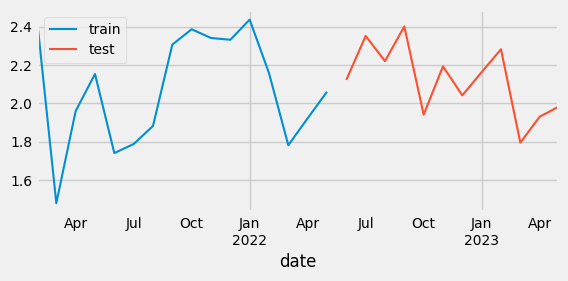

In [62]:
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['OVERALLSCORE'].plot(ax=ax, label='train')
data_test['OVERALLSCORE'].plot(ax=ax, label='test')
ax.legend();

In [63]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['OVERALLSCORE'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-02-01 00:00:00'), Timestamp('2022-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-07-07 13:37:30 
Last fit date: 2024-07-07 13:37:30 
Skforecast version: 0

In [64]:
#do the analysis for each of the most reviewed airlines (this has to be done by airline)

In [65]:
time.AIRLINENAME.value_counts() #6 airlines

AIRLINENAME
American Airlines    4912
Spirit Airlines      3972
United Airlines      3721
British Airways      2723
Frontier Airlines    2700
Delta Air Lines      2338
Name: count, dtype: int64

In [66]:
time.DATEFLOWN.max()

'2023-05-01'

In [67]:
time = time[(time.DATEFLOWN >= '2022-05-01 00:00:00')] #one year period

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 11.9668
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1696
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2974
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7610 
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7723
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8883
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9533
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2709
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2747
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6442
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7449
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2992
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9688 
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0078
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4343 


NameError: name 'airline' is not defined

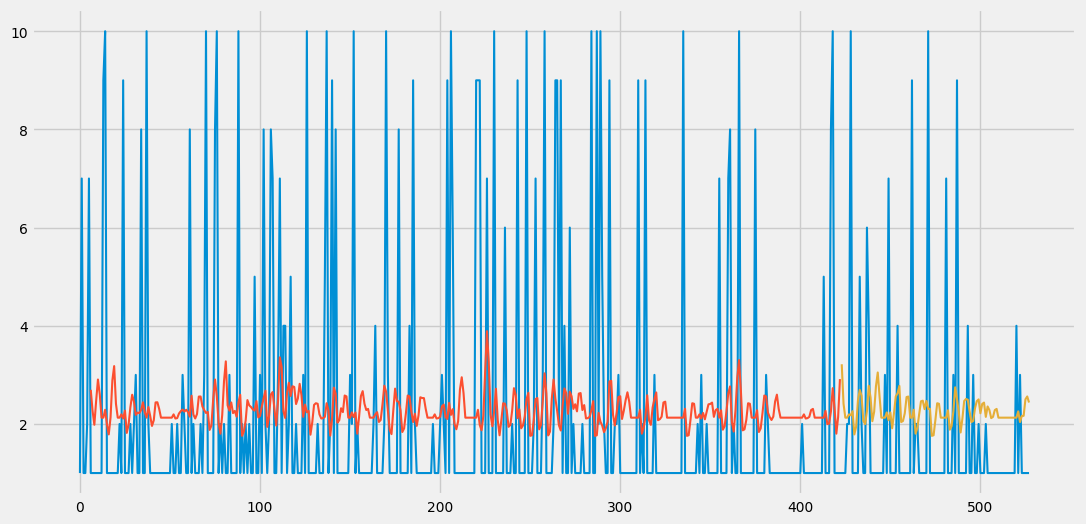

In [69]:
# Filter the dataset for the current airline
airline_data = time[time['AIRLINENAME'] == "American Airlines"]
values = airline_data['OVERALLSCORE'].values

# Preprocessing
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

sequence_length = 6  # 6 months
X, y = create_sequences(values, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=200, verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(values)), values, label='Actual Values')
plt.plot(range(sequence_length, train_size + sequence_length), train_predictions.flatten(), label='Training Predictions')
plt.plot(range(train_size + sequence_length, train_size + sequence_length + len(test_predictions)), test_predictions.flatten(), label='Test Predictions')
plt.title(f'Predictions for {airline}')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'Mean Squared Error on training : {train_mse}')
print(f'Mean Squared Error on testing: {test_mse}')

In [ ]:
#we have too much reviews so we need to lower the timeframe to get fewer reviews

In [72]:
time = time[(time.DATEFLOWN >= '2023-01-01 00:00:00')] #one year period

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 10.7805
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.8561 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.1385 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.9113
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2594
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.0605 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2341 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0047 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5099  
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0951 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0493 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1466  
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2670  
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3166 
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5263
Epoch 16/2

tensorflow WARNING 5 out of the last 18 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AB03884A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

tensorflow WARNING 6 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001AB03884A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


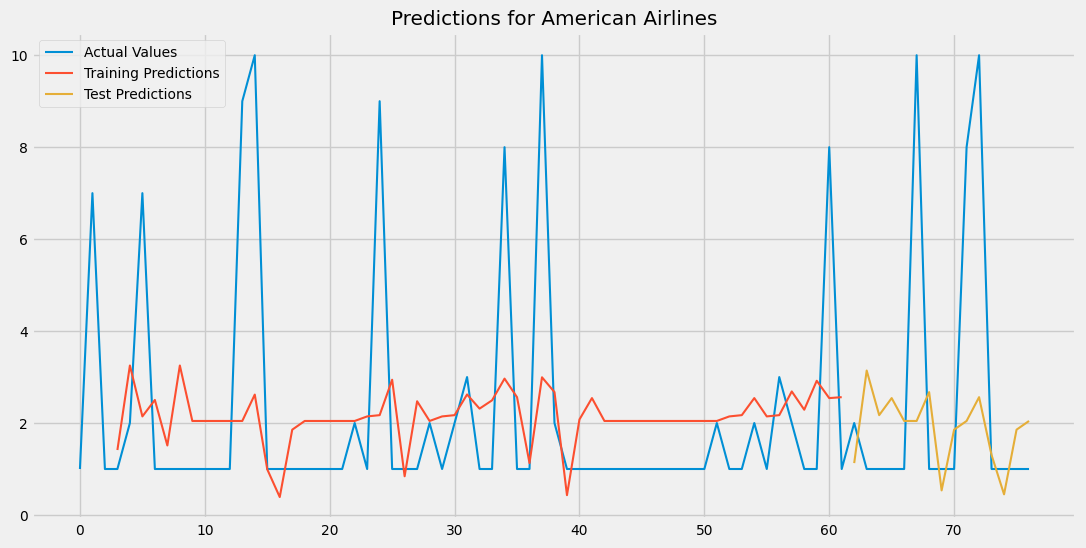

Mean Squared Error on training for American Airlines: 5.745473357692693
Mean Squared Error on testing for American Airlines: 11.347830758897581
Epoch 1/200


c:\Users\Aida\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 18.7129
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.3589 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.5093 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2633 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.8193
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.5496
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.8346 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.4673
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.3319 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.6158
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.0065 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.8542 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.3509 
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.5281 
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.3910 
Epoch 16/200
2/2

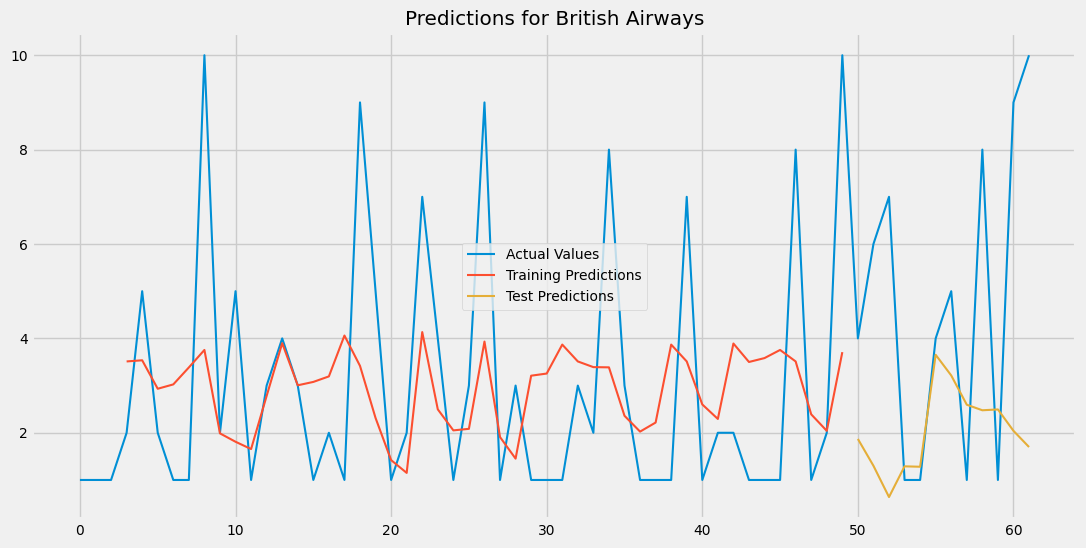

Mean Squared Error on training for British Airways: 6.678341540454029
Mean Squared Error on testing for British Airways: 18.599549029895478
Epoch 1/200


c:\Users\Aida\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.4080
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3737  
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7585 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0654 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1610 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0598 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8568 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1141 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2414 
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8129 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2098 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4269 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0576  
Epoch 14/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6156 
Epoch 15/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4864  
Epoch 16/200
6/6 ━━━━━━━━━━━━

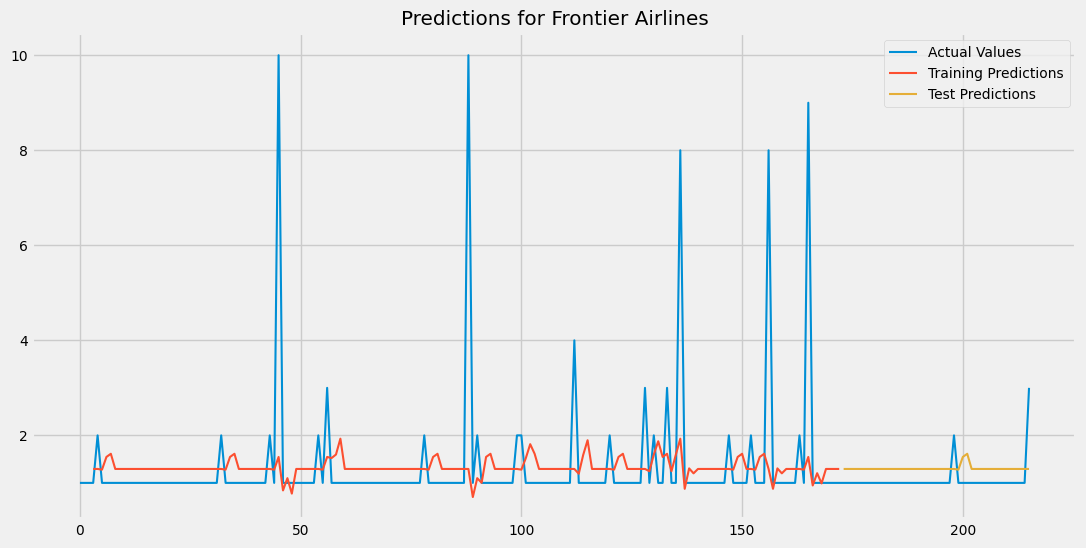

Mean Squared Error on training for Frontier Airlines: 1.913142424112194
Mean Squared Error on testing for Frontier Airlines: 0.1728975206656105
Epoch 1/200


c:\Users\Aida\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 20.3932
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.3904
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.1156 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.1813 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.7612 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.4018 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.2731 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.7594 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.5360 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.8365 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.8179 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.6959
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.6869 
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.4437 
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.2054 
Epoch 16/200
2/2 

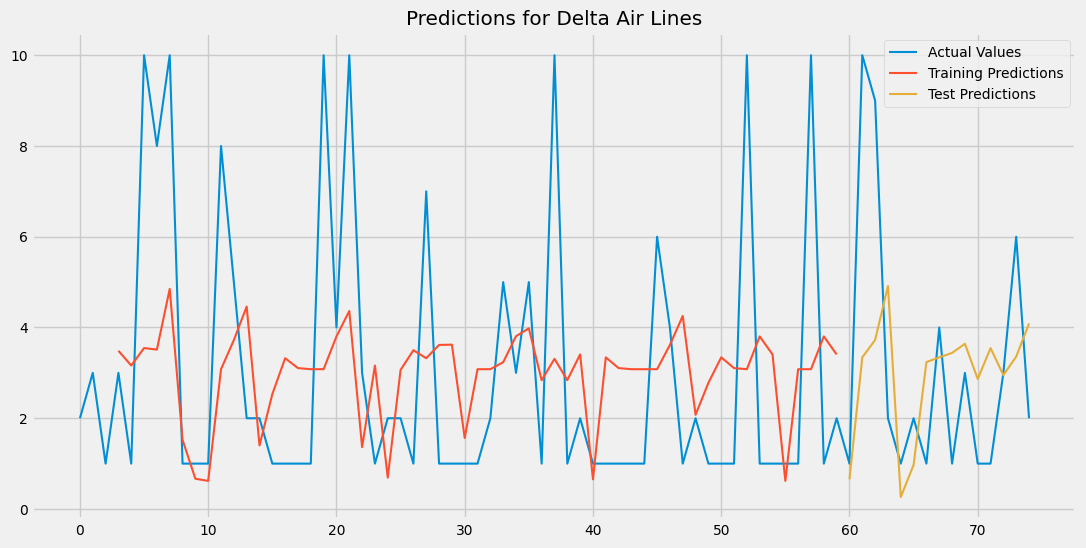

Mean Squared Error on training for Delta Air Lines: 8.854934148687331
Mean Squared Error on testing for Delta Air Lines: 7.696793139490751
Epoch 1/200


c:\Users\Aida\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.6499
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9057 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0806 
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9255 
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9057 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6985 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3223 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8161 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8996  
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2004 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4547 
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3870 
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3034 
Epoch 14/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5805 
Epoch 15/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3256 
Epoch 16/200
5/5 ━━━━━━━━━━━━━━

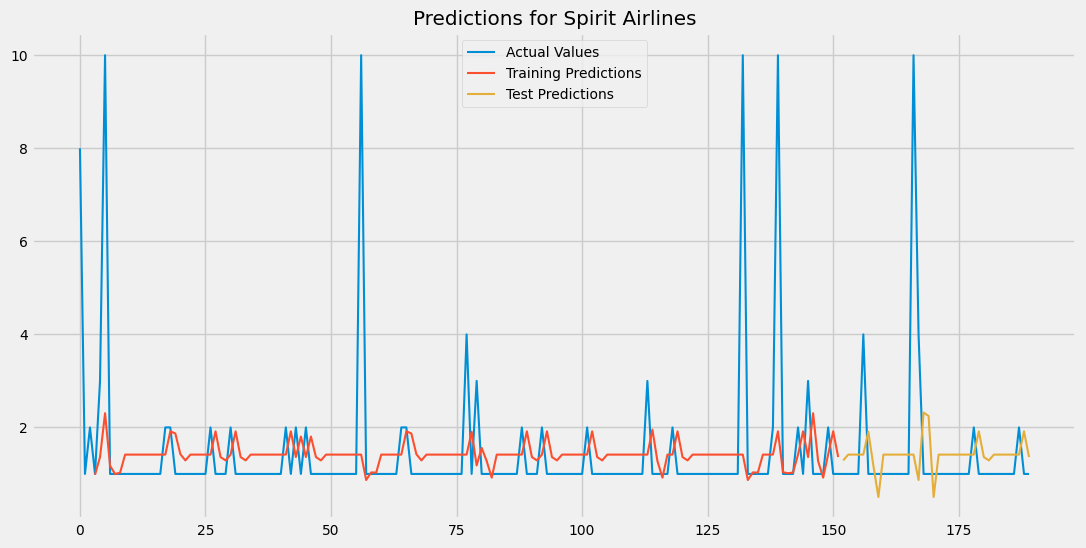

Mean Squared Error on training for Spirit Airlines: 2.1694030499514354
Mean Squared Error on testing for Spirit Airlines: 2.6640303025185763
Epoch 1/200


c:\Users\Aida\anaconda3\envs\ironhack\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.3235
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5901  
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0732 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0512 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7426 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8158  
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5616  
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4904 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1504 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0068 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1682 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9449 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5727 
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6263 
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4978 
Epoch 16/200
3/3 ━━━━━━━━━━━

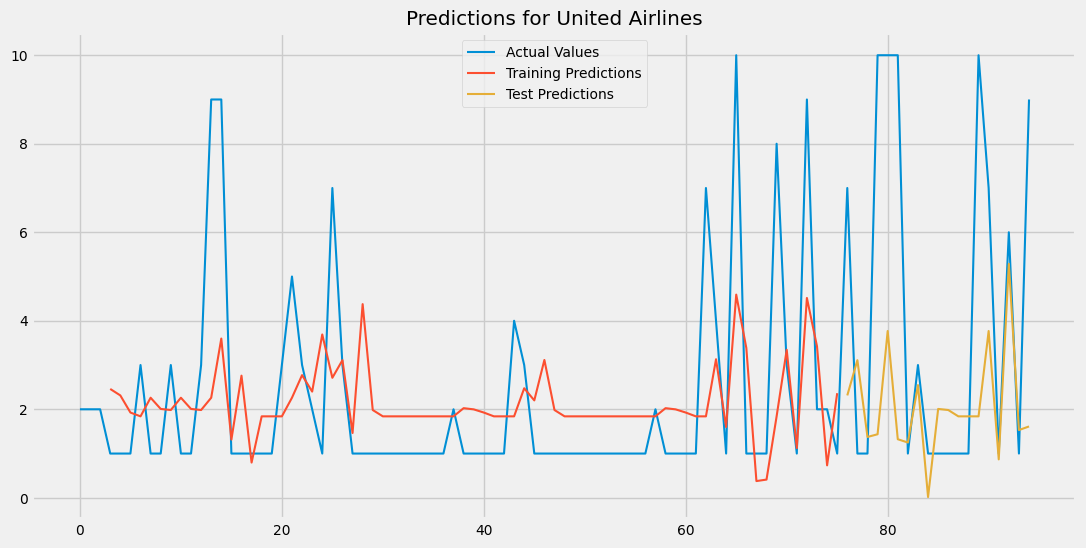

Mean Squared Error on training for United Airlines: 4.083013738605293
Mean Squared Error on testing for United Airlines: 18.475895702095034


In [74]:
for airline in time.AIRLINENAME.unique():
    # Filter the dataset for the current airline
    airline_data = time[time['AIRLINENAME'] == airline]
    values = airline_data['OVERALLSCORE'].values

    # Preprocessing
    def create_sequences(data, seq_length):
        sequences = []
        targets = []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i + seq_length])
            targets.append(data[i + seq_length])
        return np.array(sequences), np.array(targets)

    sequence_length = 3  # 3 months
    X, y = create_sequences(values, sequence_length)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=200, verbose=1)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(values)), values, label='Actual Values')
    plt.plot(range(sequence_length, train_size + sequence_length), train_predictions.flatten(), label='Training Predictions')
    plt.plot(range(train_size + sequence_length, train_size + sequence_length + len(test_predictions)), test_predictions.flatten(), label='Test Predictions')
    plt.title(f'Predictions for {airline}')
    plt.legend()
    plt.show()

    # Calculate Mean Squared Error (MSE)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    print(f'Mean Squared Error on training for {airline}: {train_mse}')
    print(f'Mean Squared Error on testing for {airline}: {test_mse}')